# Clasificador - hito 2

In [1]:
import pandas as pd
import numpy as np
import pickle

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
sns.set_theme(style="whitegrid")
plt.rc('axes', titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams.update({'lines.markeredgewidth': 1})
plt.rcParams.update({'errorbar.capsize': 2})

file_names = {
    "df_es_mapping": "../../Data/mapping/df_es_mapping.pickle",
    "df_us_mapping": "../../Data/mapping/df_us_mapping.pickle",
    
    "df_es_test": "../../Data/test/df_es_test.pickle",
    "df_us_test": "../../Data/test/df_us_test.pickle",
    
    "df_es_train": "../../Data/train/df_es_train.pickle",
    "df_us_train": "../../Data/train/df_us_train.pickle",
    
    "df_es_trial": "../../Data/trial/df_es_trial.pickle",
    "df_us_trial": "../../Data/trial/df_us_trial.pickle",
}

# mas imports
from nltk.tokenize import TweetTokenizer
tt = TweetTokenizer()

**cargar sets**

In [2]:
df_es_train = pickle.load(open(file_names["df_es_train"], "rb"))
df_es_trial = pickle.load(open(file_names["df_es_trial"], "rb"))
df_es_test = pickle.load(open(file_names["df_es_test"], "rb"))

df_us_train = pickle.load(open(file_names["df_us_train"], "rb"))
df_us_trial = pickle.load(open(file_names["df_us_trial"], "rb"))
df_us_test = pickle.load(open(file_names["df_us_test"], "rb"))

**pre-procesamiento**

In [3]:
%%time
df_us_train['tokenized_text'] = df_us_train['text'].str.lower().apply(lambda x: " ".join(tt.tokenize(x)))
df_us_train.head()

CPU times: user 21.3 s, sys: 57.3 ms, total: 21.4 s
Wall time: 21.4 s


id                                               text  \
0  729044324441186304         Selfies for summatime @ Drexel University    
1  663834134037442560  Ready to be a bulldog with rasso #hailstate #i...   
2  747449193350963200  #scored my new #matcotools #slidehammer weight...   
3  691439672761925637  @user last night was so much fun @ Skyway Thea...   
4  758118895618109440                 love beach days @ Manasquan Beach    

  label                                     tokenized_text  
0    12          selfies for summatime @ drexel university  
1    14  ready to be a bulldog with rasso #hailstate #i...  
2    16  #scored my new #matcotools #slidehammer weight...  
3     6  @user last night was so much fun @ skyway theatre  
4    12                  love beach days @ manasquan beach

In [4]:
df_us_test['tokenized_text'] = df_us_test['text'].str.lower().apply(lambda x: " ".join(tt.tokenize(x)))

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=5)
X_train_bow = vectorizer.fit_transform(df_us_train["tokenized_text"])
X_test_bow = vectorizer.transform(df_us_test["tokenized_text"])

In [6]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train_bow, df_us_train["label"]);

In [7]:
clf.score(X_train_bow, df_us_train["label"])

0.39701310639001064

In [8]:
from sklearn.metrics import classification_report

df_us_mapping = pickle.load(open(file_names["df_us_mapping"], "rb")).sort_values("label")

y_pred = clf.predict(X_test_bow)
print(classification_report(df_us_test["label"], y_pred, target_names=df_us_mapping["emoji"]))

              precision    recall  f1-score   support

           ❤       0.35      0.58      0.44     10798
           😍       0.25      0.25      0.25      4830
           📷       0.16      0.16      0.16      1432
          🇺🇸       0.47      0.50      0.48      1949
           ☀       0.25      0.43      0.32      1265
           💜       0.32      0.05      0.08      1114
           😉       0.12      0.04      0.06      1306
           💯       0.27      0.14      0.19      1244
           😁       0.14      0.03      0.05      1153
           🎄       0.60      0.60      0.60      1545
           📸       0.29      0.10      0.15      2417
           😜       0.04      0.01      0.01      1010
           😂       0.30      0.52      0.38      4534
           💕       0.19      0.05      0.08      2605
           🔥       0.45      0.47      0.46      3716
           😊       0.09      0.06      0.07      1613
           😎       0.16      0.11      0.13      1996
           ✨       0.29    

In [9]:
vocab = {k: v for v, k in enumerate(vectorizer.get_feature_names_out())}

vec_test = np.zeros(X_train_bow.shape[1])
k = vocab["santa"]
vec_test[k] = 1
print(vectorizer.inverse_transform([vec_test])[0][0])
clf.predict_proba([vec_test])

santa


array([[0.21267139, 0.10559105, 0.03170409, 0.02263593, 0.06533366,
        0.01011697, 0.02992065, 0.00932074, 0.02055197, 0.11856118,
        0.02276163, 0.02159743, 0.10988494, 0.03433423, 0.01711626,
        0.03922043, 0.05487754, 0.02576475, 0.02707579, 0.02095938]])

**GridSearch**

In [10]:
%%capture

from sklearn.metrics import f1_score, accuracy_score

dfs = [1,2,3,4,5,6,7,8,9,10]
alphas = [0, 0.2, 0.4, 0.6, 0.8, 1]

f1_m = {}
f1_w = {}
scores={}

for j in alphas:
    f1_m[j] = {}   
    f1_w[j] = {}
    scores[j] = {}
    for i in dfs:
        #Vectorización 
        vectorizer = CountVectorizer(min_df=i) #Definimos la cantidad de veces que se repite una palabra para que el clasificador la tome en consideración.
        X_train_bow = vectorizer.fit_transform(df_us_train["tokenized_text"])
        X_test_bow = vectorizer.transform(df_us_test["tokenized_text"])

        #Obtenemos el clf score para el clasificador
        clf = MultinomialNB(alpha=j)
        clf.fit(X_train_bow, df_us_train["label"])
        clf.score(X_train_bow, df_us_train["label"])

        y_pred = clf.predict(X_test_bow)
        y_true = df_us_test["label"]
        
        # Se llenan los diccionarios
        f1_m[j][i] = f1_score(y_true, y_pred, average="macro")
        f1_w[j][i] = f1_score(y_true, y_pred, average="weighted")   
        scores[j][i] = accuracy_score(y_true, y_pred)


In [11]:
scores_array = []
for i in scores:

    data = np.array(list(scores[i].values()) ).reshape(len(dfs),)
    scores_array.append(data)

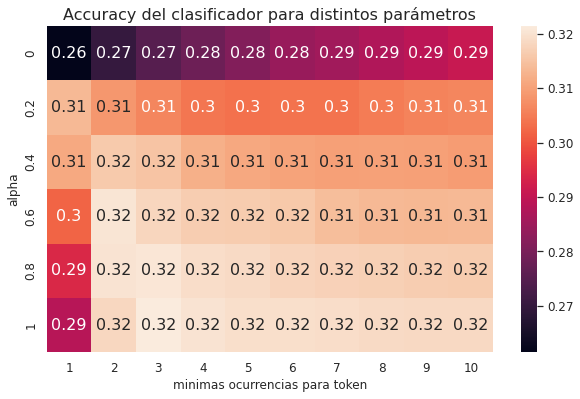

In [12]:
x_axis_labels = []

plt.title("Accuracy del clasificador para distintos parámetros")
sns.heatmap(scores_array, annot=True, xticklabels=dfs, yticklabels=alphas)
plt.xlabel('minimas ocurrencias para token')
plt.ylabel('alpha');

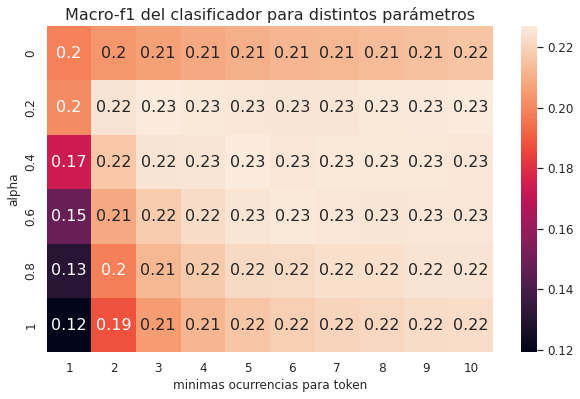

In [13]:
f1_m_array = []

for i in f1_m:

    data = np.array(list(f1_m[i].values()) ).reshape(len(dfs),) # transform to 2D
    f1_m_array.append(data)

f1_m_array

plt.title("Macro-f1 del clasificador para distintos parámetros")
sns.heatmap(f1_m_array, annot=True, xticklabels=dfs, yticklabels=alphas)
plt.xlabel('minimas ocurrencias para token')
plt.ylabel('alpha');

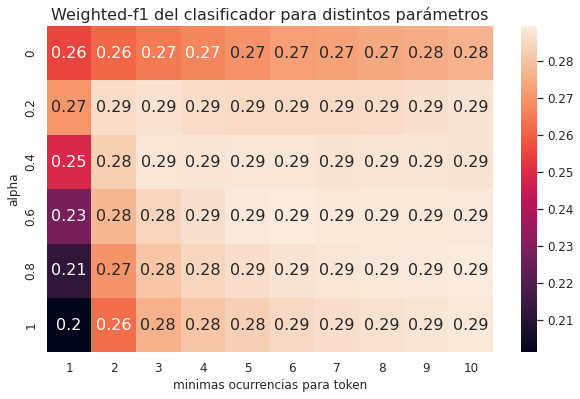

In [14]:
f1_w_array = []

for i in f1_w:
    data = np.array(list(f1_w[i].values()) ).reshape(len(dfs),) # transform to 2D
    f1_w_array.append(data)

f1_w_array

plt.title("Weighted-f1 del clasificador para distintos parámetros")
sns.heatmap(f1_w_array, annot=True, xticklabels=dfs, yticklabels=alphas)
plt.xlabel('minimas ocurrencias para token')
plt.ylabel('alpha');

Finalmente, como resulado de este grid-search, escogemos el clasificador con el mejor _macro-f1_.

In [15]:
best_alpha, best_min_df = np.unravel_index(np.argmax(np.array(f1_m_array)),shape=(len(alphas),len(dfs)))

scr, macf1, weif1 = scores_array[best_alpha][best_min_df], f1_m_array[best_alpha][best_min_df], f1_w_array[best_alpha][best_min_df]
best_alpha, best_min_df = alphas[best_alpha], dfs[best_min_df]

print("Parámetros escogidos:\n\talpha = {}\n\tminimas ocurrencias para token = {}".format(best_alpha,best_min_df))
print("Resultados de clasificación:\n\taccuracy = {}\n\tmacro f1 = {}\n\tweighted f1 = {}".format(scr,macf1,weif1))

Parámetros escogidos:
	alpha = 0.2
	minimas ocurrencias para token = 10
Resultados de clasificación:
	accuracy = 0.30642
	macro f1 = 0.22695113269450196
	weighted f1 = 0.2876509870746095


In [16]:
vectorizer = CountVectorizer(min_df=best_min_df)
X_train_bow = vectorizer.fit_transform(df_us_train["tokenized_text"])
X_test_bow = vectorizer.transform(df_us_test["tokenized_text"])

clf = MultinomialNB(alpha=best_alpha)
clf.fit(X_train_bow, df_us_train["label"])

y_pred = clf.predict(X_test_bow)
print(classification_report(df_us_test["label"], y_pred, target_names=df_us_mapping["emoji"]))

              precision    recall  f1-score   support

           ❤       0.38      0.48      0.42     10798
           😍       0.26      0.24      0.25      4830
           📷       0.14      0.17      0.16      1432
          🇺🇸       0.42      0.52      0.46      1949
           ☀       0.23      0.49      0.31      1265
           💜       0.23      0.06      0.10      1114
           😉       0.10      0.08      0.09      1306
           💯       0.21      0.20      0.20      1244
           😁       0.10      0.06      0.07      1153
           🎄       0.57      0.64      0.60      1545
           📸       0.26      0.15      0.19      2417
           😜       0.07      0.03      0.04      1010
           😂       0.33      0.47      0.39      4534
           💕       0.18      0.08      0.11      2605
           🔥       0.45      0.45      0.45      3716
           😊       0.09      0.07      0.08      1613
           😎       0.15      0.12      0.13      1996
           ✨       0.27    

### Top palabras por emoji

In [17]:
%%time
vocab_length = X_train_bow.shape[1]
proba_matrix = np.array([clf.predict_proba(np.eye(1,vocab_length,k))[0] for k in range(vocab_length)])

CPU times: user 14.5 s, sys: 200 ms, total: 14.7 s
Wall time: 2.45 s


In [18]:
print("Largo del vocabulario = {}".format(vocab_length))

Largo del vocabulario = 17777


In [19]:
def topPalabras(proba_matrix,emoji_id,k=5):
    # retorna las palabras para las cuales el emoji en cuestión tiene mas probabilidad
    prob = proba_matrix[:,emoji_id]  # mmm
    ind = np.argpartition(prob,-k)[-k:]
    val = prob[ind]
    palabras = [vectorizer.inverse_transform([np.eye(1,vocab_length,k)[0]])[0][0] for k in ind]
    return palabras, val

In [20]:
i = 9
map_emojis = df_us_mapping["label"].values
print(df_us_mapping["emoji"][int(map_emojis[i])])
topPalabras(proba_matrix,i)

🎄


(['christmasdecorations',
  'litmas',
  'xmas2016',
  'ohchristmastree',
  'christmastree'],
 array([0.72071568, 0.74812904, 0.82830986, 0.84557572, 0.84607565]))

In [21]:
for i in range(20):
    print(df_us_mapping["emoji"][int(map_emojis[i])])
    pal, val = topPalabras(proba_matrix,i)
    print(dict([(pal[j],val[j]) for j in range(len(pal))]))

❤
{'sibabes': 0.6906620911053236, '1luv': 0.7080419038362007, 'loveofmylife': 0.7274475019059425, 'cityofbrotherlylove': 0.7704815602436228, 'kfodiaries': 0.8070402343368355}
😍
{'asada': 0.5990262952613353, 'eatgood': 0.5996593037938316, 'gorg': 0.6241783754379878, 'beignet': 0.6351926966791812, 'swooning': 0.6352711964994492}
📷
{'itsamazingoutthere': 0.6389010333752864, 'acmecups': 0.660592709519073, 'gdlfashion': 0.7662663586732787, 'shredforaliving': 0.7800792961284052, 'bvillain': 0.8376467535122063}
🇺🇸
{'govote': 0.8973452218823189, 'flagday': 0.8980841887190848, 'godblessamerica': 0.9121465737229977, 'ivoted': 0.928500356765573, 'merica': 0.9191195807778645}
☀
{'funinthesun': 0.5716137881429628, 'photographer_serena': 0.757053319075366, 'sunshine': 0.6184021102032239, 'beachin': 0.6173871129611473, 'soakin': 0.6944983709464954}
💜
{'purple': 0.5960588343807284, 'ripprince': 0.6271088308339544, 'alzheimer': 0.6412853074207796, 'purplerain': 0.7114808172441944, 'endalz': 0.800189126

### Visualización de tokens según Naive Bayes

Esta seccion consiste en una visualizacion de los tokens segun la codificacion que nos entrega Naive Bayes. De la seccion anterior, se pueden obtener las probabilidad de que un token pertenezca a una clase dada. En nuestro caso, a un emoji dado. Esto es:

$$ P(w \in C) = \frac{\text{\#(tweets donde $w$ es uno de sus tokens y el tweet tiene el emoji $C$)}}{\text{\#(tweets con el token $w$)}} $$

De esta manera, cada token posee un vector de probabilidades. Donde la $C-$esima componente corresponde a $P(w \in C)$. Es decir, 

$$\vec{w} = (P(w \in C) : \text{$C$ es un emoji})$$

En particular, cada vector $\vec{w}$ es uno con tantas coordenadas como emojis (20 en Ingles). Y cada coordenada esta entre 0 y 1. Es decir, cada $\vec{w} \in [0, 1]^{\text{\#Emojis}}$.

Ahora bien, es de nuestro interes visualizar cada token segun su vector de probabilidad. Sin embargo, es necesario reducir la dimensionalidad de cada vector a una facil de interpretar (en nuestro caso 2-dimensiones). Para esto, se utiliza un metodo de reduccion de dimensionalidad denominado UMAP y ampliamente utilizado para la visualizacion de datos en altas dimensiones.

In [22]:
import umap.umap_ as umap

In [23]:
%%time
reducer = umap.UMAP(n_neighbors=15)
to_R2 = reducer.fit_transform(proba_matrix)
to_R2.shape

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


CPU times: user 59.4 s, sys: 945 ms, total: 1min
Wall time: 15.8 s


(17777, 2)

Luego de reducir los vectores de probabilidad a uno de bi-dimensional, visualizaremos segun dos aspectos el espacio de tokens. Primero, se colorean los vectores segun el emoji con mayor probabilidad. Por ejemplo, si el token $happy$ tiene mayor probabilidad de estar en la clase $smile$, entonces se asocia este token con dicho emoji. La razon de esto es solo para simplificar el analisis. Segundo, existen tokens con probabilidades maximas mas grandes que otras, es decir, tokens asociados a un mismo emoji (segun el criterio anterior) que poseen probabilidades distintas de pertenecer a dicha clase. Para observar esto, se visualizan los token con puntos de diferente tamaño y proporcional a tal probabilidad. 

In [24]:
df_umap = pd.DataFrame(to_R2)
df_umap["token"] = vectorizer.get_feature_names_out()
df_umap["label"] = map_emojis[np.argmax(proba_matrix, axis=1).astype(int)]
df_umap["proba"] = np.max(proba_matrix, axis=1)
df_umap = df_umap.merge(df_us_mapping, on="label", how="left")
df_umap

0         1         token label     proba emoji            name
0     -0.177705  4.321781            00     0  0.149490     ❤     _red_heart_
1     -1.404681  3.566153           000     0  0.138475     ❤     _red_heart_
2     -0.371582  0.889135           007     0  0.243937     ❤     _red_heart_
3      1.903484  1.820665            01     0  0.231225     ❤     _red_heart_
4      1.033077  2.755328            02     0  0.187876     ❤     _red_heart_
...         ...       ...           ...   ...       ...   ...             ...
17772  0.347587  0.319676         zumba     0  0.241695     ❤     _red_heart_
17773 -0.164445  3.247977  zumbafitness    14  0.140855     😉  _winking_face_
17774  0.608489 -1.054816           δδδ     0  0.241686     ❤     _red_heart_
17775 -0.678625 -0.585214            σκ    13  0.278696     💜  _purple_heart_
17776 -1.265634 -0.655227           σσς    13  0.440488     💜  _purple_heart_

[17777 rows x 7 columns]

In [25]:
data = []
for label in df_us_mapping["label"]:
    sub_df = df_umap[df_umap["label"] == label]
    data.append(
        go.Scattergl(
            x = sub_df[0],
            y = sub_df[1],
            mode='markers',
            text=sub_df["token"]+"<br>"+sub_df["emoji"]+"<br>"+sub_df["proba"].apply(lambda x: str(np.round(x, 3))),
            name=sub_df["emoji"].iloc[0],
            marker=dict(
                size=25*sub_df["proba"],
                line_width=0.2,
            )
        )
    )
    
fig = go.Figure(data=data)
fig.update_layout(
    title="Proyección (UMAP) de vectores de probabilidad de tokens",
    autosize=False,
    width=700,
    height=500,
)
fig.show(renderer="notebook")

**Comentarios** El top 5 de la seccion anterior se puede capturar con los primero cinco punto de mayor tamaño para un emoji dado. Tambien, se observa que la clase con mas puntos corresponde al emoji del corazon. Mismo emoji con mayor popularidad visto en la etapa de analisis de los datos. Se observan grupos diferenciados, pero que logran solaparse. Esta zona coincide con aquellos tokens con probabilidades uniformes de pertenecer a cada clase y/o con probabilidad maxima cercanas a 0.1.

**Distribución de clases usando subsampling**

In [26]:
df_us_train1 = pickle.load(open(file_names["df_us_train"], "rb"))

In [27]:
print("Distribucion de clases original")
counts = df_us_train1['label'].value_counts()
counts

Distribucion de clases original


0     83611
1     40934
2     40396
4     20042
3     19991
5     18493
6     17127
7     13890
10    13035
9     12671
8     12662
11    11758
15    10734
18    10721
14    10689
12    10515
16    10474
17     9969
13     9898
19     9682
Name: label, dtype: int64

In [36]:
min_freq = np.min(counts.values)
min_class = list(counts.index)[np.argmin(counts.values)]
print("Mínima frecuencia entre las distintas clases = {}\nEmoji class = {}".format(min_class,min_class))

Mínima frecuencia entre las distintas clases = 19
Emoji class = 19


In [37]:
reduce_index = list(counts.index)
reduce_index.remove(min_class)

In [38]:
for label in reduce_index:
    freq = counts[label]
    delete_counts = freq - min_freq
    df_us_train1 = df_us_train1.reset_index(drop=True)
    ## subsampling sobre la clase label
    idx = np.random.choice(df_us_train1.loc[df_us_train1.label == label].index, size=delete_counts, replace=False)
    data_subsampled = df_us_train1.drop(df_us_train1.iloc[idx].index, inplace = True)


In [39]:
%%time
df_us_train1['tokenized_text'] = df_us_train1['text'].str.lower().apply(lambda x: " ".join(tt.tokenize(x)))
df_us_train1.head()

CPU times: user 9.02 s, sys: 15.9 ms, total: 9.04 s
Wall time: 9.1 s


id                                               text  \
0  729044324441186304         Selfies for summatime @ Drexel University    
1  663834134037442560  Ready to be a bulldog with rasso #hailstate #i...   
2  747449193350963200  #scored my new #matcotools #slidehammer weight...   
3  758118895618109440                 love beach days @ Manasquan Beach    
4  689978401587892224                    With COCO @ New York, New York    

  label                                     tokenized_text  
0    12          selfies for summatime @ drexel university  
1    14  ready to be a bulldog with rasso #hailstate #i...  
2    16  #scored my new #matcotools #slidehammer weight...  
3    12                  love beach days @ manasquan beach  
4    16                    with coco @ new york , new york

In [40]:
df_us_test['tokenized_text'] = df_us_test['text'].str.lower().apply(lambda x: " ".join(tt.tokenize(x)))

In [41]:
vectorizer = CountVectorizer(min_df=10)
X_train_bow1 = vectorizer.fit_transform(df_us_train1["tokenized_text"])
X_test_bow = vectorizer.transform(df_us_test["tokenized_text"])
clf = MultinomialNB(alpha = .2)
clf.fit(X_train_bow1, df_us_train1["label"])

clf.score(X_train_bow1, df_us_train1["label"])

0.37795909935963645

In [42]:
df_us_mapping = pickle.load(open(file_names["df_us_mapping"], "rb")).sort_values("label")

y_pred = clf.predict(X_test_bow)
print(classification_report(df_us_test["label"], y_pred, target_names=df_us_mapping["emoji"]))

              precision    recall  f1-score   support

           ❤       0.45      0.10      0.16     10798
           😍       0.26      0.14      0.19      4830
           📷       0.13      0.20      0.16      1432
          🇺🇸       0.34      0.56      0.42      1949
           ☀       0.18      0.56      0.27      1265
           💜       0.09      0.12      0.10      1114
           😉       0.07      0.13      0.09      1306
           💯       0.15      0.30      0.20      1244
           😁       0.07      0.11      0.09      1153
           🎄       0.44      0.70      0.54      1545
           📸       0.21      0.21      0.21      2417
           😜       0.05      0.08      0.06      1010
           😂       0.39      0.28      0.32      4534
           💕       0.14      0.17      0.15      2605
           🔥       0.46      0.41      0.44      3716
           😊       0.08      0.10      0.09      1613
           😎       0.13      0.11      0.12      1996
           ✨       0.22    

**Conclusiones**

A partir del subsampling, se puede observar que los resultados no presentan una mejorar e incluso en varias clases disminuye la efectividad del clasificador, por lo que es mejor no hacer el subsampling para obtener mejores metricas.